<a href="https://colab.research.google.com/github/Smit250904/image-caption-segment/blob/main/image_caption_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.3 MB/s eta 0:00:00


In [ ]:
import streamlit as st
from PIL import Image
import torch
import torchvision
from torchvision import transforms
import numpy as np
import cv2
from transformers import BlipProcessor, BlipForConditionalGeneration

# Load models once
@st.cache_resource
def load_models():
    caption_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    caption_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
    seg_model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    caption_model.eval()
    seg_model.eval()
    return caption_processor, caption_model, seg_model

processor, cap_model, seg_model = load_models()

st.title("🧠 Image Captioning & Segmentation")
st.write("Upload an image and get a caption with segmentation overlay.")

uploaded_file = st.file_uploader("Upload an image", type=["jpg", "png", "jpeg"])
if uploaded_file:
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Uploaded Image", use_column_width=True)

    # === Captioning ===
    inputs = processor(image, return_tensors="pt")
    with torch.no_grad():
        out = cap_model.generate(**inputs)
    caption = processor.decode(out[0], skip_special_tokens=True)
    st.subheader("📝 Caption")
    st.write(caption)

    # === Segmentation ===
    transform = transforms.Compose([transforms.ToTensor()])
    img_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        prediction = seg_model(img_tensor)

    np_image = np.array(image)

    for i in range(min(3, len(prediction[0]['masks']))):
        score = prediction[0]['scores'][i].item()
        if score > 0.5:
            mask = prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()
            box = prediction[0]['boxes'][i].cpu().numpy()
            rgba_mask = cv2.applyColorMap(mask, cv2.COLORMAP_JET)
            np_image = cv2.addWeighted(np_image, 1.0, rgba_mask, 0.5, 0)
            x1, y1, x2, y2 = box.astype(int)
            cv2.rectangle(np_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    st.subheader("🎯 Segmented Image")
    st.image(np_image, use_column_width=True)


2025-06-22 15:21:45.486 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-22 15:21:45.490 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-22 15:21:45.490 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-22 15:21:45.492 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-22 15:21:45.493 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-22 15:21:45.494 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-22 15:21:45.495 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-22 15:21:45.496 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [ ]:
!streamlit run app.py

Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: app.py


📝 Caption: a dog with its tongue out


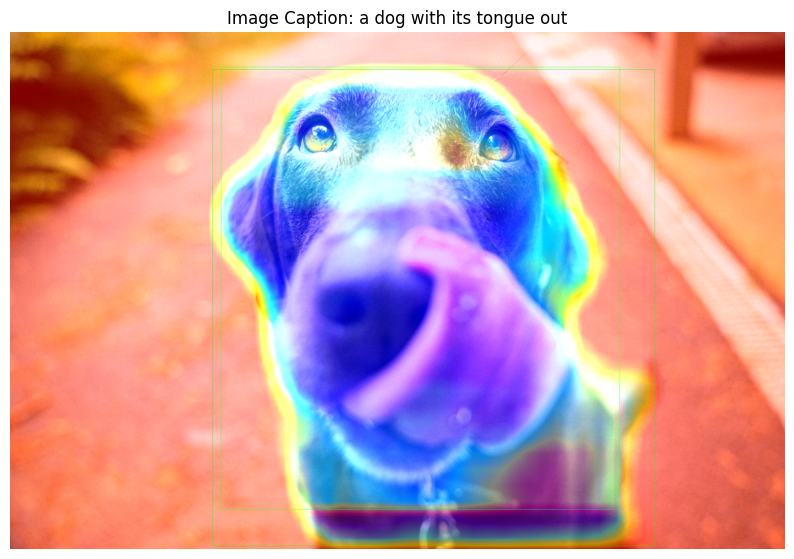

In [6]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import requests
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Image URL
img_url = "https://images.unsplash.com/photo-1518717758536-85ae29035b6d"
image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")

# ===== IMAGE CAPTIONING =====
caption_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
caption_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
caption_model.eval()

caption_inputs = caption_processor(image, return_tensors="pt")
with torch.no_grad():
    caption_output = caption_model.generate(**caption_inputs)

caption = caption_processor.decode(caption_output[0], skip_special_tokens=True)
print("📝 Caption:", caption)

# ===== IMAGE SEGMENTATION =====
seg_model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
seg_model.eval()

transform = transforms.Compose([transforms.ToTensor()])
img_tensor = transform(image).unsqueeze(0)

with torch.no_grad():
    prediction = seg_model(img_tensor)

# Convert image for overlay
np_image = np.array(image)

# Draw top 3 masks and bounding boxes
for i in range(min(3, len(prediction[0]['masks']))):
    score = prediction[0]['scores'][i].item()
    if score > 0.5:
        mask = prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()
        label = prediction[0]['labels'][i].item()
        box = prediction[0]['boxes'][i].cpu().numpy()
        rgba_mask = cv2.applyColorMap(mask, cv2.COLORMAP_JET)
        np_image = cv2.addWeighted(np_image, 1.0, rgba_mask, 0.5, 0)

        # Draw bounding box
        x1, y1, x2, y2 = box.astype(int)
        cv2.rectangle(np_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display image with caption and segmentation
plt.figure(figsize=(10, 10))
plt.imshow(np_image)
plt.title(f"Image Caption: {caption}")
plt.axis("off")
plt.show()
